In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


In [3]:
from torchvision.models import resnet18
import torchvision.transforms.v2 as transforms

# Do we need a softmax layer?

We saw in the previous notebook how the vectors for each output class of the softmax layer acts as a kind of centroid or prototype, and the neural network solves the classification problem by mapping the inputs as close as possible to these protype vectors. We could see that the "as close to possible" actually meant that it tries to minimize the angle between the prototype vector and the transformed examples. We explained this more explicitly has the neural network having two components: an encoder and a decoder. The encoder is trained to map the inputs to an _intermediate representation_ which is then used to solve the problem by the decoder. In a deep neural network, it's our choice of where we want to divide the stack of layers into "encoder" and "decoder", but it often has to do with what layer we think the representations might be useful on.

The way we described the _encoder_ and _decoder_ in the previous notebook was like this:
$$
\mathbf{z} = f_{enc}(\mathbf{x})
$$

The decoder then maps the input vector to a categorical distribution:
$$
\mathbf{\hat{y}} = f_{dec}(\mathbf{z})
$$

The decoder is what drives the learning of the upstreams neural network. In our case, the decoder is simply a matrix multiplication;
$$
\mathbf{\hat{y}} = W_s \mathbf{z} = \begin{bmatrix}\mathbf{w}_{1} \\ \mathbf{w}_{2} \\ \vdots \\ \mathbf{w}_{c} \end{bmatrix} \mathbf{z} = \begin{bmatrix}\mathbf{w}_{1} \cdot \mathbf{z} \\ \mathbf{w}_{2} \cdot \mathbf{z} \\ \vdots \\ \mathbf{w}_{c} \cdot \mathbf{z} \end{bmatrix}
$$

The $w_i$ here are our softmax vectors, and the result of our output is actually the _unscaled_ cosine of the angle between the transformed input and our softmax vectors.

Now imagine that instead of having some _fixed_ prototype vector we dynamically compute these vectors. Let's take one data point per each of our $k$ classes, we'll call them $\mathbf{x}_{c_1}, \mathbf{x}_{c_2}, \dots, \mathbf{x}_{c_k}$. Instead of having a fixed and learned softmax weight $w_{c_i}$ we will use our encoder to compute these: 

$$
\mathbf{w}_{c_i} = f_{enc}(\mathbf{x}_{c_i})
$$

So given some input $\mathbf{x}$ to our network we get this instead:

$$
\begin{align*}
\mathbf{z} &= f_{enc}(\mathbf{x})\\
\mathbf{\hat{y}} &= \begin{bmatrix}f_{enc}(\mathbf{x}_{c_1}) \cdot \mathbf{z} \\ f_{enc}(\mathbf{x}_{c_2}) \cdot  \mathbf{z} \\ \vdots \\ f_{enc}(\mathbf{x}_{c_k}) \cdot \mathbf{z} \end{bmatrix}
\end{align*}
$$

Why would we want to do this? One important thing to notice is that we've now freed ourselves from the constraint of having _exactly_ $K$ output vectors (one for each class). We could instead easily extend the number of classes we have without having to retrain the network. While this is neat, the real reason for doing this comes when we ask ourselves _"what vectors should we choose to be the $f_{enc}(\mathbf{x}_{c_i})$ vectors?"_

## Which inputs should we use to compute the "softmax vectors"?

On the face of it, the above formulation doesn't really give us anything, we've just replaced the softmax vectors with free parameters to some vectors computed by the network. If we trained using this formulation, we would still get to the same place: the network would try to move all the inputs of a class close to its corresponding prototype. We're encouraging the network to learn a _similarity_ between the protype vector and the training data. This is a very powerful idea which we can use to instead of just learning a mapping to some fixed set of vectors, we try to learn a mapping to a _space_ where similar things are close together. The goal of doing this is to get more _general_ representaitons, in particular for transfer learning. 

We'll see how we can do this by instead of choosing a specific vector to act as a "prototype" vector, we let **all** vectors play this role. Let's have a look at this again:

$$
\mathbf{z} = f_{enc}(\mathbf{x})
$$

Where $\mathbf{x}$ is some example in the dataset

$$
\begin{align*}
\mathbf{z} &= f_{enc}(\mathbf{x})\\
\mathbf{\hat{y}} &= \begin{bmatrix}f_{enc}(\mathbf{x}_{c_1}) \cdot \mathbf{z} \\ f_{enc}(\mathbf{x}_{c_2}) \cdot  \mathbf{z} \\ \vdots \\ f_{enc}(\mathbf{x}_{c_k}) \cdot \mathbf{z} \end{bmatrix}
\end{align*}
$$



### Does categorical cross entropy still make sense?

With the change we've now done, we're longer really modelling a categorical probability distribution. We still wan't to achive something similar as we did before, that the learning objective leads to a encoder which maps our data into a new "neural" space, where things which are similar (according to us humans) are close together (according to some metric). We saw in the previous example that the cross-entropy loss (what we used to train our spherical softmax)  worked to produce these kind of representations. 

We can still use the softmax and cross entropy, and to get an intuition into what this would model let's go back to the classification model. When training a classifier, we're modelling the probability that a certain input (e.g. an image) should be associated with a certain label. When we switch to the setup we've discribed, we instead model the probability that an image should be associated with another set of images.





### Setting up the dataset
We start by setting up the data again. Just as before we'll use MNIST, but now we will create an extended dataset that returns a pair of associated images instead of an image and a label. We do this by simply wrapping the original dataset in a new dataset.

In [4]:
import torch
from torch import nn
import torchvision.transforms.v2 as transforms
from torchvision.datasets import MNIST


class ExpandChannels(nn.Module):
    def __init__(self, num_channels=3):
        super().__init__()
        self.num_channels = num_channels
    
    def forward(self, img):
        # Count channels from back, so we can use it both for single examples and batches
        *leading_dims, n_channels, height, width = img.shape
        if n_channels != self.num_channels:
            repeats = [1 for d in leading_dims] + [self.num_channels, 1, 1]
            new_img = img.repeat(*repeats)
        else:
            new_img = img
        return new_img
        
    

dataset_transforms = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True), ExpandChannels(3)])
mnist_train_dataset = MNIST(root='../datasets', download=True, transform=dataset_transforms)
mnist_test_dataset = MNIST(root='../datasets', train=False, download=True, transform=dataset_transforms)
num_classes = len(mnist_train_dataset.classes)

In [5]:
from sklearn.model_selection import train_test_split
train_indices, dev_indices = train_test_split(np.arange(len(mnist_train_dataset)),  test_size=0.1, random_state=42, stratify=mnist_train_dataset.targets)


In [6]:
train_images, train_targets = zip(*[mnist_train_dataset[i] for i in train_indices])
dev_images, dev_targets = zip(*[mnist_train_dataset[i] for i in dev_indices])



In [7]:
train_images = torch.stack(train_images)
train_targets = torch.tensor(train_targets)
dev_images = torch.stack(dev_images)
dev_targets = torch.tensor(dev_targets)

In [8]:
from torch.utils.data import TensorDataset
mnist_train_split_dataset = TensorDataset(train_images, train_targets)
mnist_dev_split_dataset = TensorDataset(dev_images, dev_targets)

We'll setup the pairwise dataset like this: we take the original dataset and create pairs of all images which belong to the same label. We will create this virtually, not actually creating any pairs but instead use maths to figure out what two example belong to any specific pair.
We don't want to assume that the number of samples per class is the same, so we need to keep track of how many virtual pairs there are in each class.

  Note that this leads to a rather large virtual dataset, each class in our base training dataset has about 5400 images, so we'll get roughly 14 million pairs per class, leading to about 140 million pairs in total. To handle this we'll sample the pairs during training, not going through the whole dataset.

In [9]:
import numpy as np
from torch.utils.data import Dataset
from itertools import combinations




def find_indices(n, local_index):
    # One way of thinking about what we're doing here is to 
    # imagine the pairs as the entries in the upper triangle of a matrix formed by the 
    # indices. We then first select the "row" by dividing by the total number of 
    # indices, and then the column by taking the modulo of the indices. Note that 
    # the pairs are distinct, so the local index 0 should lead to the pair with index (0,1)
    
    # The solution below is quite inefficient, and wouldn't work very well if n is large since we're 
    # actually creating the full index arrays before taking the _one_ pair we're interested in.
    # An alternative method is to simply calculate what the indices should be, but 
    # this leads to maths which is a bit much to digest in a workshop like this.
    # This  solution is fast enough for what we're doing now though
    
    a_indices, b_indices = np.triu_indices(n, k=1)
    a = a_indices[local_index]
    b = b_indices[local_index]    
    
    return (a, b)



class PairwiseLabeledDataset(Dataset):
    def __init__(self, wrapped_dataset) -> None:
        super().__init__()
        # here we create the pairwise book-keeping. We do this by keeping track of 
        # how many examples there are per class, and then calculate how many 
        # pairs there should be based on this. We can then use this to determine 
        # what an index into all the pairs should point to.
        
        self.wrapped_dataset = wrapped_dataset

        self.targets = wrapped_dataset.tensors[1]
        self.target_n_pairs = dict()
        self.target_indices = dict()
        # We'll sort it so we get a consistent dataset.
        self.target_labels = sorted(np.unique(self.targets))
        
        for target in self.target_labels:
            target_indices, = np.where(self.targets==target)  # np.where() returns a tuple with the index along each axis. In our case we only have a single axis but we still have to unpack the tuple: hence the comma after the *target_indices*
            self.target_indices[target] = target_indices
            # The number of pairs are the number of size-2 subsets we can form from the target indices
            # This is the binomial coefficient n choose 2, which is (n*(n-1))/2
            n = len(target_indices)
            n_pairs = n*(n-1)//2
            self.target_n_pairs[target] = n_pairs
        
        self.target_intervals = []
        start = 0
        for target in self.target_labels:
            self.target_intervals.append(start)
            start += self.target_n_pairs[target]
        self.target_intervals.append(start)
        self.n = start # Since we added the number of the final target, this gives us the full length
            
    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        start = 0
        local_index = index
        for i, target in enumerate(self.target_labels):
            start, end = self.target_intervals[i:i+2]
            if start <= index < end:
                local_index -= start
                target_indices = self.target_indices[target]
                n = len(target_indices)
                a_index, b_index = find_indices(n, local_index)
                a_wrapped_dataset_index = target_indices[a_index]
                b_wrapped_dataset_index = target_indices[b_index]
                a, target = self.wrapped_dataset[a_wrapped_dataset_index]
                b, target = self.wrapped_dataset[b_wrapped_dataset_index]
                return a, b, target
        # If we get here, we got an index error
        raise IndexError(f"Index {index} outside of range for dataset with length {len(self)}")
            


In [10]:
pairwise_training_dataset = PairwiseLabeledDataset(mnist_train_split_dataset)
pairwise_dev_dataset = PairwiseLabeledDataset(mnist_dev_split_dataset)

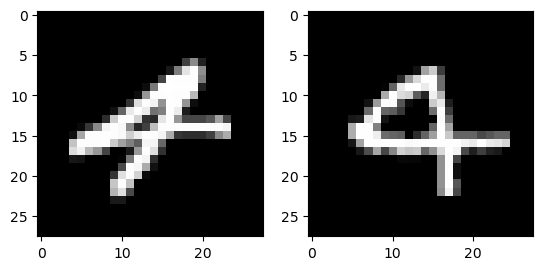

In [11]:
import matplotlib.pyplot as plt
a,b,c = pairwise_training_dataset[146193071//2]
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(a.permute(1, 2, 0).numpy())
ax2.imshow(b.permute(1, 2, 0).numpy())

### The visualization subset

To illustrate what the model learns, we'll select a subset of the training data to use to calculate features. The reason for selecting a subset of the training data is for us to understand what the model is actually doing while it's learning.

In [12]:
# Well make a small subselection of the training samples
n = 20
visualization_sample_index, _ = train_test_split(np.arange(len(train_images)), shuffle=True, stratify=train_targets, train_size=n*num_classes)
visualization_images = torch.stack([train_images[i] for i in visualization_sample_index])
visualization_targets = torch.stack([train_targets[i] for i in visualization_sample_index])
visualization_dataset = TensorDataset(visualization_images, visualization_targets)
#pairwise_visualization_dataset = PairwiseLabeledDataset(visualization_dataset)  # We don't need to have a pairwise dataset for the visualizations


## The model
We modify our previous model somewhat. The main difference is that we'll no longer project down the features to the classifcation layer, instead we apply only a single linear transformation followed by the normalization.

In [13]:
import torch
from torch.nn.functional import normalize
from torchvision.models import resnet18
import torchvision.transforms.v2 as transforms

device = torch.device('cuda')


model = resnet18(weights=None)

# Determine the number of input features to the output layer:
num_ftrs = model.fc.in_features


class SphericalProjectionHead(nn.Module):
    def __init__(self, input_dimension, bottleneck_dimension=2, rng=None):
        super().__init__()
        if rng is None:
            rng = np.random.default_rng()
        self.input_dimension = input_dimension
        self.bottleneck_dimension = bottleneck_dimension
        
        self.input_transform = nn.Parameter(torch.tensor(rng.normal(size=(input_dimension, bottleneck_dimension)), dtype=torch.float32)              )
    
    def forward(self, x):
        x_reduced = torch.matmul(x, self.input_transform)
        x_normalized = normalize(x_reduced, dim=-1) # By using -1, we're saying that the normalization should be along the innermost axis.
        return x_normalized

rng = np.random.default_rng(1729)
prediction_head = SphericalProjectionHead(num_ftrs, bottleneck_dimension=2, rng=rng)
model.fc = prediction_head

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training the network

We've now trained the network using our pairwise data setup. We'll directly optimize the cosine distance as our targets.

### Constructing the targets
Our data will come in a triplet of three tensors; $A, B, \mathbf{c}$. $A$ and $B$ are the input images and will be of shape $(\text{batch\_size}, \text{num\_channels}, \text{height}, \text{width})$. We're going to pass these through our network and get the matrix results:

$$
f(A) = \begin{bmatrix}\mathbf{h}_{A_1}^T\\\mathbf{h}_{A_2}^T\\\vdots\\\mathbf{h}_{A_n}^T\\\end{bmatrix} = \begin{bmatrix}h_{A_1, 1} &  \dots & h_{A_1, d} \\ h_{A_2, 1} &  \dots & h_{A_2, d} \\ \vdots & \ddots & \vdots \\ h_{A_n, 1} &  \dots & h_{A_n, d} \end{bmatrix},
f(B) = \begin{bmatrix}\mathbf{h}_{B_1}^T\\\mathbf{h}_{B_2}^T\\\vdots\\\mathbf{h}_{B_n}^T\\\end{bmatrix} = \begin{bmatrix}h_{B_1, 1} &  \dots & h_{B_1, d} \\ h_{B_2, 1} &  \dots & h_{B_2, d} \\ \vdots & \ddots & \vdots \\ h_{B_n, 1} &  \dots & h_{B_n, d} \end{bmatrix}
$$

the $\mathbf{h}$ vectors here are the $L_2$ normalized (i.e. they have Euclidean length 1) feature vectors we get out of our neural network. We then take the matrix multiplication of these two to get:

$$
D = f(A) f(B)^T = \begin{bmatrix}\mathbf{h}_{A_1}^T\\\mathbf{h}_{A_2}^T\\\vdots\\\mathbf{h}_{A_n}^T\\\end{bmatrix} \begin{bmatrix}\mathbf{h}_{B_1}&\mathbf{h}_{B_2}&\dots&\mathbf{h}_{B_n}\end{bmatrix} = 
\begin{bmatrix} \mathbf{h}_{A_1}^T \mathbf{h}_{B_1} & \mathbf{h}_{A_1}^T \mathbf{h}_{B_2} & \dots & \mathbf{h}_{A_1}^T \mathbf{h}_{B_n} \\
                \mathbf{h}_{A_2}^T \mathbf{h}_{B_1} & \mathbf{h}_{A_2}^T \mathbf{h}_{B_2} & \dots & \mathbf{h}_{A_2}^T \mathbf{h}_{B_n} \\
                \vdots &  \ddots & \dots & \vdots \\
                \mathbf{h}_{A_n}^T \mathbf{h}_{B_1} & \mathbf{h}_{A_n}^T \mathbf{h}_{B_2} & \dots & \mathbf{h}_{A_n}^T \mathbf{h}_{B_n}
\end{bmatrix} = 
\begin{bmatrix} \cos(\theta_{\mathbf{h}_{A_1}, \mathbf{h}_{B_1}}) & \cos(\theta_{\mathbf{h}_{A_1}, \mathbf{h}_{B_2}}) & \dots & \cos(\theta_{\mathbf{h}_{A_1}, \mathbf{h}_{B_n}}) \\
                \cos(\theta_{\mathbf{h}_{A_2}, \mathbf{h}_{B_1}}) & \cos(\theta_{\mathbf{h}_{A_2}, \mathbf{h}_{B_2}}) & \dots & \cos(\theta_{\mathbf{h}_{A_2}, \mathbf{h}_{B_n}}) \\
                \vdots &  \ddots & \dots & \vdots \\
                \cos(\theta_{\mathbf{h}_{A_n}, \mathbf{h}_{B_1}}) & \cos(\theta_{\mathbf{h}_{A_n}, \mathbf{h}_{B_2}}) & \dots & \cos(\theta_{\mathbf{h}_{A_n}, \mathbf{h}_{B_n}}) \\
                
\end{bmatrix}
$$

So in the end we get an $n \times n$ matrix (where $n = \text{batch\_size}$) with all the pairwise cosine of the angles between the feature vectors from the network. **Please note that this matrix is not symmetric**

We will train our models to make this angle small when the pairs are of the same label, and large when they are not. To capture this more like a distance metric, we'll use the _cosine distance_. Since the cosine of an angle goes from $1$ (the vectors point in the same direcion) to $-1$ (the vectors point in opposite direction) we can get a pseudo distance metric by just taking:

$$
\text{cosine distance} = 1 - D
$$

Now vectors which are pointing in the same direction has the distance $0$, and those pointing in the opposite direction has the distance $2$. Orthogonal vector will have distance 1. It's often highlighted that this isn't a true distance metric (i.e. the triangle inequality does not hold) but for our purposes it will work to do what we want.

We will now construct a loss function which decreases as the angle between _correct_ pairs decrease but increases when the angle between _incorrect_ pairs decrease. This is easily done by creating a matrix with $1 and -1$, which we multiply with the matrix of cosine distances. Correct pairs will have their distance be multiplied by 1, the loss will then be minimized when the the angle between the vectors is 0. Incorrect pairs will have their distance multiplied by -1, so when their angle decreases, the loss instead increases.
 
To construct this loss-mask we start by taking the "outer" product of our target vector using comparison, which will create a boolean matrix where elements are `True` for correct pairs and `False` for negative ones:

In [14]:
#Example target vector
a = torch.randint(5, (6,))
a

tensor([1, 4, 2, 0, 4, 4])

In [15]:
# The unsqueeze adds a singleton dimension. So the comparison below will be between two 2D-arrays. 
# The left hand side will have shape (1, 5) and the right hand side will have shape (5, 1). 
# Pytorch inherits numpy's broadcasting semantics in this case and a good intuition is to 
# think about what the result would be if we were matrix-multiplying two matrices of these shapes.
# The first row will be the comparison of the left hand argument with the first element of 
# the right hand argument and so on.
target_mask = a.unsqueeze(0) == a.unsqueeze(1)
target_mask

tensor([[ True, False, False, False, False, False],
        [False,  True, False, False,  True,  True],
        [False, False,  True, False, False, False],
        [False, False, False,  True, False, False],
        [False,  True, False, False,  True,  True],
        [False,  True, False, False,  True,  True]])

Once we've constructed this matrix, by casting it to float we make all `True` entries become $1.0$ and all the `False` entries become $0.0$.

In [16]:
target_mask = target_mask.to(dtype=torch.float)  # True-values will be converted to 1.0, False-values to 0.0
target_mask

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 1.],
        [0., 1., 0., 0., 1., 1.]])

Now we can just scale and shift this matrix to get the desired values:

In [17]:
loss_coefficients = 2*target_mask - 1
loss_coefficients

tensor([[ 1., -1., -1., -1., -1., -1.],
        [-1.,  1., -1., -1.,  1.,  1.],
        [-1., -1.,  1., -1., -1., -1.],
        [-1., -1., -1.,  1., -1., -1.],
        [-1.,  1., -1., -1.,  1.,  1.],
        [-1.,  1., -1., -1.,  1.,  1.]])

This is the procedure we will use to construct the loss-scaling below, which will encourage our model to learn the distances we are interested in. Since we're likely to have many more `False` pairs than `True` ones, we might wan't to weigh these differently. This can be achieved by choosing different scaling and subtraction values. For example if we want the weights of the correct pairs to be $4.2$ and those of the incorrect to be $0.1$ we simply use the formula: 
$$
S = (c_{\text{positive}} + c_{\text{negative}}) M - c_{\text{negative}}
$$
where $M$ is the binary matrix and $S$ is the final loss mask

In [18]:
# example of using the coefficients 4.2 and 0.1
c_positive = 4.2
c_negative = 0.1
loss_coefficients =  (c_positive + c_negative)*target_mask - c_negative
loss_coefficients

tensor([[ 4.2000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000],
        [-0.1000,  4.2000, -0.1000, -0.1000,  4.2000,  4.2000],
        [-0.1000, -0.1000,  4.2000, -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000,  4.2000, -0.1000, -0.1000],
        [-0.1000,  4.2000, -0.1000, -0.1000,  4.2000,  4.2000],
        [-0.1000,  4.2000, -0.1000, -0.1000,  4.2000,  4.2000]])

We will use this construction in the training loop below to construct the loss by multiplying this mask with our cosine angle matrix.

In [19]:
from torch.utils.data import DataLoader, RandomSampler
from tqdm.notebook import tqdm, trange
import torch

device = torch.device('cuda')

batch_size = 8
c_positive = 1
c_negative = 1

# The pairwise datasets now effectively contain millions of pairs. 
# We don't want to iterate through all of them, but will instead 
# sample a number for each epoch. The number of samples per dataset is given below
train_samples = batch_size * 20
dev_samples = batch_size * 10


training_sampler = RandomSampler(pairwise_training_dataset, replacement=False, num_samples=train_samples)
dev_sampler = RandomSampler(pairwise_dev_dataset, replacement=False, num_samples=dev_samples)

# This is a leftover from sampling the visualization dataset as a pair-dataset. 
# It's better to not do this, instead just taking the images from the backing dataset

# We create our own sampler here because we want to have a fixed random subset of the visualization set
# visualization_samples = 800
class FixedRandomSampler:
    def __init__(self, dataset, num_samples=None, generator=None):
        if generator is None:
            generator = torch.default_generator
        self.dataset = dataset
        self.generator = generator
        shuffled_indices = torch.randperm(len(dataset), generator=self.generator)
        self.indices = shuffled_indices[:num_samples]
        self.n = num_samples

    def __len__(self):
        return self.n
    
    def __iter__(self):
        yield from self.indices
        

train_dataloader = DataLoader(pairwise_training_dataset, batch_size=batch_size, sampler=training_sampler, num_workers=2, persistent_workers=True)
dev_dataloader = DataLoader(pairwise_dev_dataset, batch_size=batch_size, sampler=dev_sampler, num_workers=2, persistent_workers=True)
visualization_dataloader = DataLoader(visualization_dataset, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=2, persistent_workers=True)



In [20]:

epochs = 1
sample_step = 20
n_iterations = 0

visualization_representations = {i: [] for i in range(epochs)}
visualization_targets = None

epoch_progress_bar = trange(epochs, desc="Epoch")
train_progress_bar = trange(len(train_dataloader), desc="Train batch")
dev_progress_bar = trange(len(dev_dataloader), desc="Dev batch")

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    model.train()
    
    train_progress_bar.reset()
    dev_progress_bar.reset()    
    for train_batch in train_dataloader:
        optimizer.zero_grad()
        # The difference now is that each batch consists of two inputs sets
        a_inputs, b_inputs, targets = train_batch
        a_features = model(a_inputs.to(device))
        b_features = model(b_inputs.to(device))
        targets = targets.to(device)
        # Instead of using a softmax, we'll think of the problem as a 
        # binary classification problem. 
        # We'll do this by taking the matrix multiplication of the a and b features.
        # Note that we need to transpose the b-features to create the result
        cosine_distances = 1. - torch.matmul(a_features, b_features.T)
        
        # The question is now what targets to use. Our features are a matrix of all 
        # the pairwise cosine distances. We want to create a similar target matrix, 
        # where the elements are 1 if the pair have the same label and 0 otherwise.
        # We do this by taking a kind of "outer product"; using the torch broadcasting 
        # semantic. This matrix will be symmetric, but keep in mind that the cosine 
        # distance matrix is not.
        target_matrix = targets.unsqueeze(0) == targets.unsqueeze(1)
        target_mask_binary = target_matrix.to(dtype=cosine_distances.dtype)  # True-values will be converted to 1.0, False-values to 0.0
        loss_coefficients =  (c_positive + c_negative)*target_mask_binary - c_negative
        loss_matrix = cosine_distances * loss_coefficients
        loss = torch.sum(loss_matrix)
        
        loss.backward()
        
        optimizer.step()
        if n_iterations % sample_step == 0:
            with torch.no_grad():
                model.eval()
                viz_features = []
                viz_targets = []
                
                for viz_batch in visualization_dataloader:
                    images, targets = viz_batch
                    features = model(images.to(device))

                    viz_features.append(features.cpu())
                    viz_targets.append(targets.cpu())
                    
                concatenated_viz_features = torch.concat(viz_features).numpy()
                if visualization_targets is None:
                    concatenated_viz_targets = torch.concat(viz_targets).numpy()
                    visualization_targets = concatenated_viz_targets

                visualization_representations[n_iterations//sample_step] = concatenated_viz_features

            model.train()
        n_iterations += 1
        train_progress_bar.update()
        
    
    with torch.no_grad():
        model.eval()
        total_dev_loss = 0
        n_dev_samples = 0
        for dev_batch in dev_dataloader:
            a_inputs, b_inputs, targets = dev_batch
            a_features = model(a_inputs.to(device))
            b_features = model(b_inputs.to(device))
            targets = targets.to(device)
            cosine_distances = torch.matmul(a_features, b_features.T)
            target_matrix = targets.unsqueeze(0) == targets.unsqueeze(1)
            target_mask_binary = target_matrix.to(dtype=cosine_distances.dtype)  # True-values will be converted to 1.0, False-values to 0.0
            loss_coefficients =  (c_positive + c_negative)*target_mask_binary - c_negative
            loss_matrix = cosine_distances * loss_coefficients
            loss = torch.sum(loss_matrix)
        
            n = len(a_inputs)
            n_pairs = n*(n-1)//2
            batch_loss = loss.item() * n_pairs
            total_dev_loss += batch_loss
            n_dev_samples += n_pairs
            dev_progress_bar.update()
        #print("Dev loss: ", total_dev_loss/n_dev_samples)
    epoch_progress_bar.update()
        
        
        

        
        

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train batch:   0%|          | 0/20 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
#from matplotlib.animation import FuncAnimation
from ipywidgets import interact
import ipywidgets as widgets

#fig, ax = plt.subplots(figsize=(8,8))

initial_representations = visualization_representations[0]

cmap = plt.get_cmap('tab10')
cNorm  = colors.Normalize(vmin=min(train_targets), vmax=max(train_targets))

class_index_to_value = {i: v for v,i in mnist_train_dataset.class_to_idx.items()}
class_index_to_color = {i: cmap(cNorm(i)) for i in class_index_to_value.keys()}

x_lim = (-1.1, 1.1)
y_lim = (-1.1, 1.1)

def update_plot(epoch):
    figure = plt.figure(figsize=(6,6))
    representations = visualization_representations[epoch]
    #targets = visualization_targets[epoch]
    n=len(representations)
    plt.scatter(representations[:,0], representations[:,1], alpha=.5, edgecolors=[class_index_to_color[x] for x in visualization_targets], facecolors='none')
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.title(f"{len(representations[:,0])}")

interact(update_plot, epoch=widgets.IntSlider(min=0, max=max(visualization_representations.keys()), step=1, value=0))
    

interactive(children=(IntSlider(value=0, description='epoch', max=0), Output()), _dom_classes=('widget-interac…

<function __main__.update_plot(epoch)>

## Working with multimodal data

In the example above, we've used MNIST to make the connection between calassification and constrastive learning clear. This has been mainly for us to get a good intuitiuon about what constrastive learning does. We'll now work with multimodal data instead. Due to the workshop format, we've opted for a small dataset. In reality you would want large amounts of data for contrastive learning to give good results.

The dataset we will look at is not really built for multimodal learning, but instead for [Visual Question Answering in Radiology](https://osf.io/89kps/). Download the dataset from [here](https://files.osf.io/v1/resources/89kps/providers/osfstorage/?zip=&_gl=1*b9zgsy*_ga*MTQyNzczMDM3NS4xNzEwODI3MTU4*_ga_YE9BMGGWX8*MTcxMDgzOTE0MS4yLjEuMTcxMDgzOTIxNC41OS4wLjA.) and extract the resulting zip archive in the same directory as this notebook. 

You should now have the following files and directories:
```
Readme.docx
VQA_RAD Dataset Public.json
VQA_RAD Dataset Public.xlsx
VQA_RAD Dataset Public.xml
VQA_RAD Image Folder/
```

We will use the images in the `VQA_RAD Image Folder` and the metadata in `VQA_RAD Dataset Public.json`. The metadata is in so called JavaScript Object Notation (JSON) where each file in the image folder has metadata which looks like this:

```json
{
      "qid": "0",
      "phrase_type": "freeform",
      "qid_linked_id": "03f451ca-de62-4617-9679-e836026a7642",
      "image_case_url": "https://medpix.nlm.nih.gov/case?id=48e1dd0e-8552-46ad-a354-5eb55be86de6",
      "image_name": "synpic54610.jpg",
      "image_organ": "HEAD",
      "evaluation": "not evaluated",
      "question": "Are regions of the brain infarcted?",
      "question_rephrase": "NULL",
      "question_relation": "NULL",
      "question_frame": "NULL",
      "question_type": "PRES",
      "answer": "Yes",
      "answer_type": "CLOSED"
}
```

In [24]:
from pathlib import Path
metadata_file = Path('VQA_RAD Dataset Public.json')
image_root = Path('VQA_RAD Image Folder')
# If you extracted the content to a subdirectory you can uncomment the following lines:
#metadata_file = Path('osfstorage-archive/VQA_RAD Dataset Public.json')
#image_root = Path('osfstorage-archive/VQA_RAD Image Folder')


Let's have a look at how this metadat looks:

In [25]:
import json
with open(metadata_file) as fp:
    metadata = json.load(fp)
metadata

[{'qid': '0',
  'phrase_type': 'freeform',
  'qid_linked_id': '03f451ca-de62-4617-9679-e836026a7642',
  'image_case_url': 'https://medpix.nlm.nih.gov/case?id=48e1dd0e-8552-46ad-a354-5eb55be86de6',
  'image_name': 'synpic54610.jpg',
  'image_organ': 'HEAD',
  'evaluation': 'not evaluated',
  'question': 'Are regions of the brain infarcted?',
  'question_rephrase': 'NULL',
  'question_relation': 'NULL',
  'question_frame': 'NULL',
  'question_type': 'PRES',
  'answer': 'Yes',
  'answer_type': 'CLOSED'},
 {'qid': 1,
  'phrase_type': 'freeform',
  'qid_linked_id': '06e26b2c-04b9-42bc-8e98-1de30a0f7682',
  'image_case_url': 'https://medpix.nlm.nih.gov/case?id=b197277b-6960-4175-86ee-d2cb23e381b3',
  'image_name': 'synpic29265.jpg',
  'image_organ': 'CHEST',
  'evaluation': 'not evaluated',
  'question': 'Are the lungs normal appearing?',
  'question_rephrase': 'NULL',
  'question_relation': 'NULL',
  'question_frame': 'NULL',
  'question_type': 'ABN',
  'answer': 'No',
  'answer_type': 'CLO

We will now create a dataset we can use for this. We will 

In [90]:
from torch.utils.data import Dataset
import numpy as np
from torchvision.io import read_image

class VQADataset(Dataset):
    def __init__(self, root_dir: Path = Path(), transforms=None, subset_indices=None) -> None:
        super().__init__()
        self.root = root_dir
        self.metadata_file = root_dir / 'VQA_RAD Dataset Public.json'
        self.image_root = root_dir / 'VQA_RAD Image Folder'
        self.transforms = transforms
        
        with open(self.metadata_file) as fp:
            unstructured_metadata = json.load(fp)
            self.metadata = {record['image_name']: record for record in unstructured_metadata }
        
        self.images = [image_path for image_path in self.image_root.glob('*.jpg') if image_path.name in self.metadata]
        if subset_indices is None:
            subset_indices = np.arange(len(self.images))
        self.subset_indices = subset_indices
    
    def __len__(self):
        return len(self.subset_indices)
    
    def __getitem__(self, subset_index):
        full_index = self.subset_indices[subset_index]
        image_path = self.images[full_index]
        image_metadata = self.metadata[image_path.name]
        image = read_image(str(image_path))
        if self.transforms is not None:
            image = self.transforms(image)
        return image, image_metadata

In [91]:
vqadataset = VQADataset(Path('osfstorage-archive'))

In [92]:
vqadataset[0][0].shape

torch.Size([3, 720, 960])

In [93]:
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torchvision.transforms.v2 as transforms


dev_preprocess = transforms.Compose([transforms.ToDtype(torch.float32, scale=True), transforms.Resize([224, 224])])
train_preprocess = transforms.Compose([transforms.AutoAugment(), transforms.RandomResizedCrop(224), transforms.ToDtype(torch.float32, scale=True), transforms.Resize([224, 224])])

train_indices, dev_indices = train_test_split(np.arange(len(vqadataset)),  test_size=0.1, random_state=42)
vqa_train_dataset = VQADataset(Path('osfstorage-archive'), subset_indices=train_indices, transforms=train_preprocess)
vqa_dev_dataset = VQADataset(Path('osfstorage-archive'), subset_indices=dev_indices, transforms=dev_preprocess)


In [64]:
vqa_train_dataset[0][0].shape


torch.Size([3, 224, 224])

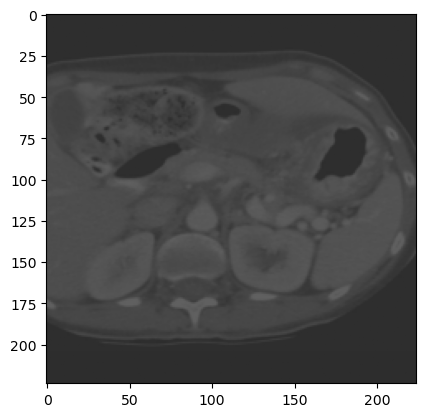

In [65]:
import matplotlib.pyplot as plt
image = vqa_train_dataset[0][0].permute(1,2,0).numpy()  # Matplotlibs expects the channel last
plt.imshow(image)

## The models
We now have two different modalities; one is the image and we'll use a resnet like before. The other modality is text; and to make this workshop simple we'll use a pretrained neural network to get the text modality. [CLIP](https://github.com/openai/CLIP) from OpenAI is an easy to use, very powerful, multimodal model where we will use its text encoder for our dataset. We will not train the text encoder now, but instead use it to practically compute dynamic softmax vectors like we discussed previously.

In [66]:
!pip install ftfy regex tqdm && pip install git+https://github.com/openai/CLIP.git

1227.37s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y4dsa_g3
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-y4dsa_g3
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


We can now use clip as a text encoder like this (model checkpoints will automatically be downloaded):

In [68]:

import torch
import clip
from PIL import Image

model, preprocess = clip.load("ViT-B/32", device=device)

In [69]:
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text)

The `encode_text()` method takes a batch of strings prepared with the `clip.tokenize` function. We can then use these vectors as the text feature which we want to minimze the image features angles towards, very similar to if these were softmax target vectors.

In [76]:
import torch
from torch.nn.functional import normalize
from torchvision.models import resnet18
import torchvision.transforms.v2 as transforms

device = torch.device('cuda')

clip_model, preprocess = clip.load("ViT-B/32", device=device)

# We'll determine the dimensionality of the clip feature vectors by simply passing an example through it
text = clip.tokenize(["a test"]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text)
    clip_feature_dimension = text_features.shape[-1]


rng = np.random.default_rng(1729)
image_encoder = resnet18(weights=None)

# Determine the number of input features to the output layer of the resnet model:
num_ftrs = image_encoder.fc.in_features
# We use the clip feature vectors as our targets
image_encoder_head  = SphericalProjectionHead(num_ftrs, bottleneck_dimension=clip_feature_dimension, rng=rng)
image_encoder.fc = image_encoder_head
image_encoder.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training the multimodal model
In the example where the pairs where of the same modality and essentially drawn from the same class created a loss coefficient matrix with the assumption thath any of the pairs could actually be correct pairs. In the multimodal setting that is often not the assumption. Instead we assume that there are singleton correct pairs: the ones we actually have in the dataset. If some images in our example would have the exact same question, we'll ignore this and just assume that most of the time the images in a batch are not similar.

This simplifies our loss function, so instead of taking an arbitrary coefficient matrix, we'll just use the identity matrix. We're also going to switch what loss function we use. Instead of taking the cosine distance, we'll consider each row and column of our feature times feature matrix as logits for categorical probability distributinos and use softmax instead. This is the exact setup used in the CLIP training.

### What text to use?
In the dataset, we actually have multiple different fields which could be interesting to use. We'll be flexible and defer the choice of what metadata field to use when we construct the batches. This makes it easier to extend the training to use other fields than the ones we select here.

In [94]:
import torch
import clip

def collate_function(batch):
    images, records = zip(*batch)
    images = torch.stack(images)
    texts = [f"Question: {record['question']}, Answer: {record['answer']}" for record in records]
    encoded_texts = clip.tokenize(texts)
    return images, encoded_texts

In [96]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(vqa_dev_dataset, collate_fn=collate_function, batch_size=4)
for batch in test_dataloader:
    images, text = batch

In [97]:
from torch.utils.data import DataLoader, RandomSampler
from tqdm.notebook import tqdm, trange
import torch

device = torch.device('cuda')

batch_size = 32
train_dataloader = DataLoader(vqa_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True, collate_fn=collate_function)
dev_dataloader = DataLoader(vqa_dev_dataset, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True, collate_fn=collate_function)

In [98]:

from torchvision.models import resnet18
import torchvision.transforms.v2 as transforms

device = torch.device('cuda')


model = resnet18(weights=None)

# Determine the number of input features to the output layer:
num_ftrs = model.fc.in_features


class SphericalProjectionHead(nn.Module):
    def __init__(self, input_dimension, bottleneck_dimension=2, rng=None):
        super().__init__()
        if rng is None:
            rng = np.random.default_rng()
        self.input_dimension = input_dimension
        self.bottleneck_dimension = bottleneck_dimension
        
        self.input_transform = nn.Parameter(torch.tensor(rng.normal(size=(input_dimension, bottleneck_dimension)), dtype=torch.float32)              )
    
    def forward(self, x):
        x_reduced = torch.matmul(x, self.input_transform)
        x_normalized = normalize(x_reduced, dim=-1) # By using -1, we're saying that the normalization should be along the innermost axis.
        return x_normalized

In [99]:
from torch.nn.functional import normalize

epochs = 1
n_iterations = 0

epoch_progress_bar = trange(epochs, desc="Epoch")
train_progress_bar = trange(len(train_dataloader), desc="Train batch")
dev_progress_bar = trange(len(dev_dataloader), desc="Dev batch")

optimizer = torch.optim.AdamW(image_encoder.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
    image_encoder.train()
    
    train_progress_bar.reset()
    dev_progress_bar.reset()    
    for train_batch in train_dataloader:
        optimizer.zero_grad()
        images, texts = train_batch
        image_features = image_encoder(images.to(device))
        with torch.no_grad():
            text_features = clip_model.encode_text(texts.to(device))
            text_features = normalize(text_features, dim=-1)
            text_features = text_features.to(dtype=image_features.dtype)
        cosine_sims = torch.matmul(image_features, text_features.T)
        targets = torch.arange(len(images)).to(device=device)
        print(targets)
        
        row_losses = loss_fn(cosine_sims, targets)
        col_losses = loss_fn(cosine_sims.T, targets)
        loss = row_losses + col_losses
        loss.backward()
        
        optimizer.step()
        
        n_iterations += 1
        train_progress_bar.update()
        
    
    with torch.no_grad():
        model.eval()
        total_dev_loss = 0
        n_dev_samples = 0
        for dev_batch in dev_dataloader:
            images, texts = dev_batch
            image_features = image_encoder(images.to(device))
            text_features = clip_model.encode_text(texts.to(device))
            text_features = normalize(text_features, dim=-1)
            
            cosine_sims = torch.matmul(image_features, text_features.T)
            targets = torch.arange(len(images), device=images.device)
            
            row_losses = loss_fn(cosine_sims, targets)
            col_losses = loss_fn(cosine_sims.T, targets)
            loss = row_losses + col_losses
            loss.backward()
            
            n = len(images)*2
            batch_loss = loss.item() * n
            total_dev_loss += batch_loss
            n_dev_samples += n
            dev_progress_bar.update()
        print("Dev loss: ", total_dev_loss/n_dev_samples)
    epoch_progress_bar.update()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train batch:   0%|          | 0/9 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/1 [00:00<?, ?it/s]

## Evaluating the learned representations
We can now use our image encoder to create vector representations and then use these to find similar examples in our dataset.